## Ingest_clearing_spreadsheets
The idea here is to use the google sheets API to ingest the information stored in the core facility clearing google sheets into the braincogs00 database. We will be making a new database table for each clearing protocol spreadsheet. These will be linked to the Experiments() table in the database by the experiment_id primary key.

In [ ]:
import pickle
import os.path
from datetime import datetime
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
import pandas as pd
import datajoint as dj

## Google Spreadsheet API setup

We will be using the Google Sheets API: https://developers.google.com/sheets/api/quickstart/python

For details on how to set this up on your machine, see this notebook: [Microscope_management.ipynb](Microscope_management.ipynb).

In [2]:
# Set the scope to be read only since we are not adding anything to the google sheet, just reading it
SCOPES = ['https://www.googleapis.com/auth/spreadsheets.readonly']

secrets_file = 'credentials.json' # Has to be called "credentials.json"  
assert os.path.exists(secrets_file)

In [3]:
def retrieve_google_sheet(spreadsheet_id,range_query):
    """
    ---PURPOSE---
    Gets the data from the range of cells in the google sheet specified.
    """
    creds = None
    # The file token.pickle stores the user's access and refresh tokens, and is
    # created automatically when the authorization flow completes for the first
    # time.
    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            creds = pickle.load(token)
    # If there are no (valid) credentials available, let the user log in.
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                secrets_file, SCOPES)
            creds = flow.run_local_server(port=0)
        # Save the credentials for the next run
        with open('token.pickle', 'wb') as token:
            pickle.dump(creds, token)

    service = build('sheets', 'v4', credentials=creds)

    # Call the Sheets API
    sheet = service.spreadsheets()
    result = sheet.values().get(spreadsheetId=spreadsheet_id,
                                range=range_query).execute()
    values = result.get('values', [])

    return values

## Defining the database table
Since we are going to be adding a table to an existing database in datajoint, we will first need to connect to the database

In [10]:
# Need to port forward 3306 from jtb3-dev@pni.princeton.edu first (set this up externally on the machine)
db = dj.create_virtual_module(module_name='lightsheet',schema_name='ahoag_test',create_schema=False,
                                 create_tables=True)

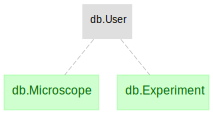

In [11]:
# Show the current structure of the database via the "Entity Relationship Diagram (ERD)"
dj.ERD(db)

In [12]:
db.User()

username user in the lab,email
apv2,apv2@princeton.edu
ejdennis,Ejdennis@princeton.edu
jverpeut,jverpeut@princeton.edu
marlies.oostland,marlies.oostland@princeton.edu
mioffe,mioffe@princeton.edu
pbibawi,pbibawi@princeton.edu
rmallarino,rmallarino@princeton.edu
soline,soline@princeton.edu
willmore,Willmore@princeton.edu
zhihaoz,zhihaoz@princeton.edu


In [ ]:
@db.schema #  
class IdiscoPlusClearing(dj.Manual): # dj.Manual is one of the 4 datajoint table types - Manual corresponds to externally inputted data
    definition = """ # iDISCO+ clearing logs 
    -> db.Experiment                     # experiment_id, the primary key from the Experiment() table
    ----
    -> db.User                           # username, the researcher's netid from the User() table
    clearer                              :   varchar(20)   # the netid of the person who entered the row
    exp_notes                            :   varchar(200)  # Note anything unusual that happened to subject that could affect clearing
    perfusion_date                       :   date 
    time_dehydration_step1               :   datetime
    time_dehydration_step2               :   datetime
    time_dehydration_step3               :   datetime
    time_dehydration_step4               :   datetime
    time_dehydration_step5               :   datetime
    time_dehydration_step6               :   datetime
    time_dehydration_step7               :   datetime
    time_dehydration_step8               :   datetime
    time_dehydration_step9               :   datetime
    time_rehydration_step1               :   datetime
    time_rehydration_step2               :   datetime
    time_rehydration_step3               :   datetime
    time_rehydration_step4               :   datetime
    time_rehydration_step5               :   datetime
    time_rehydration_step6               :   datetime
    time_rehydration_step7               :   datetime
    time_rehydration_step8               :   datetime
    time_rehydration_step9               :   datetime
    time_blocking_step1                  :   datetime
    time_blocking_step2                  :   datetime
    time_primary_antibody_step1          :   datetime
    time_primary_antibody_step2          :   datetime
    time_primary_antibody_step3          :   datetime
    primary_antibody_notes               :   varchar(500)
    time_wash1_step1                     :   datetime
    time_wash1_step2                     :   datetime
    time_wash1_step3                     :   datetime
    time_wash1_step4                     :   datetime
    time_wash1_step5                     :   datetime
    time_wash1_step6                     :   datetime    
    time_secondary_antibodies_step1      :   datetime
    secondary_antibody_notes             :   varchar(500)
    time_wash2_step1                     :   datetime
    time_wash2_step2                     :   datetime
    time_wash2_step3                     :   datetime
    time_wash2_step4                     :   datetime
    time_wash2_step5                     :   datetime
    time_wash2_step6                     :   datetime    
    time_clearing_step1                  :   datetime
    time_clearing_step2                  :   datetime
    time_clearing_step3                  :   datetime
    time_clearing_step4                  :   datetime
    time_clearing_step5                  :   datetime
    time_clearing_step6                  :   datetime  
    time_clearing_step7                  :   datetime
    time_clearing_step8                  :   datetime
    time_clearing_step9                  :   datetime
    time_clearing_step10                 :   datetime
    time_clearing_step11                 :   datetime
    clearing_notes                       : varchar(500)
    """

In [ ]:
IdiscoPlusClearing()

## Fill the iDISCO+ table from the Google Sheet

In [ ]:
SPREADSHEET_ID = '1iy4H8kHocnu9sS9P-NZA8qcp6_R4gj0ogwksl3I-suU' # The copy of the clearing spreadsheet, where I made some formatting changes to make it more consistent.
# We are in readonly (see SCOPES) so we cannot destroy it by accident.
range_query = 'iDISCO+!A5:BF14' # Syntax is Sheet_name!cell_start:cell_end, e.g. 
values = retrieve_google_sheet(spreadsheet_id=SPREADSHEET_ID,range_query=range_query)

In [13]:
# Only does this if the table does not already exist.
def fill_iDISCO_table():
    if len(IdiscoPlusClearing.fetch()) != 0:
        sys.exit("Delete contents of table first before repopulating!")
    
    column_names = [x for x in IdiscoPlusClearing.heading.attributes.keys()]
#     print(len(column_names))
    for row in values:
        clearer='zmd'
        email = row[0]
        username = email.split('@')[0].lower() if 'princeton' in email else 'zmd' # zahra is the only one who used her gmail
        title, description = row[1:3]
        exp_query = db.Experiment() & f'title = "{title}"' & f'username = "{username}"'
        print(exp_query)
#         print(description)
#         print(row[0:5])
#         if len(row) < 2:
#             continue
#         try:
#             date_str = datetime.strptime(row[0], "%B %d, %Y").strftime("%Y-%m-%d")
#         except:
#             date_str = 'unknown'
#         for ii in range(len(column_names)-len(row)):
#             row.append('')
#         insert_row = ['ahoag',date_str] + row[1:]    
#         insert_dict = {column_names[ii]:insert_row[ii] for ii in range(len(column_names))}
#         Microscope().insert1(insert_dict,skip_duplicates = True)

In [ ]:
fill_iDISCO_table()

In [ ]:
db.Experiment()

So we can see that the data were inserted (if you uncommented the line above). 

## Removing data from the database

In [ ]:
# To delete, simply wrap a query in parentheses whose row results are the ones you want to delete
# and use the delete() method

(Microscope() & 'swapper="Austin"').delete()

In [ ]:
# Using delete_quick() will override the interactive double-check
(Microscope() & 'swapper="Austin"').delete_quick()